In [1]:
f = open("./M1109BUSM293NNBR.csv", "r").read()

In [43]:
import numpy as np
import pandas as pd

class GBMSimulator:
    def __init__(self, historical_returns: pd.DataFrame):
        """
        historical_returns: DataFrame with columns as indices and rows as monthly returns (in decimal form, e.g., 0.01 for 1%)
        """
        self.historical_returns = historical_returns
        self.params = self._estimate_gbm_params()

    def _estimate_gbm_params(self):
        """
        Estimate drift (mu) and volatility (sigma) per index.
        """
        params = {}
        for index in self.historical_returns.columns:
            returns = self.historical_returns[index].dropna()
            mu = returns.mean()
            sigma = returns.std()
            params[index] = {'mu': mu, 'sigma': sigma}
        return params

    def simulate(self, n_months: int, seed: int):
        """
        Simulate GBM paths for each index.
        Returns: dict of index_name -> np.array of simulated returns (starting at time 1).
        """
        np.random.seed(seed)
        simulations = {}

        for index, param in self.params.items():
            mu, sigma = param['mu'], param['sigma']
            # Generate random standard normal values
            z = np.random.normal(size=n_months)
            # GBM log returns: log(1 + r_t)
            log_returns = (mu - 0.5 * sigma**2) + sigma * z
            # Convert log returns to arithmetic returns
            returns = np.exp(log_returns) - 1
            simulations[index] = returns

        return simulations

    def get_simulated_return(self, index: str, seed: int, t: int, n_months=240):
        """
        Get the simulated return at month t for given index and seed.
        """
        if index not in self.params:
            raise ValueError(f"Index '{index}' not found in historical data.")
        if t >= n_months:
            raise ValueError(f"t={t} is beyond the simulated range of {n_months} months.")

        sim_returns = self.simulate(n_months, seed)
        return sim_returns[index][t]


In [48]:
import pandas as pd

def load_returns_from_csv(file_path: str, index_name: str = 'Index'):
    """
    Loads a CSV with 'date' and 'value' columns and returns a DataFrame
    with monthly returns, suitable for GBMSimulator.

    The result will be a DataFrame with a single column named after the index.
    """
    df = pd.read_csv(file_path, parse_dates=['observation_date'])
    df = df.sort_values('observation_date')

    # Calculate returns
    df['return'] = df['M1109BUSM293NNBR'].pct_change()

    # Drop the first row with NaN
    df = df.dropna(subset=['return'])

    # Format into DataFrame for simulator
    df_returns = df[['observation_date', 'return']].copy()
    df_returns.set_index('observation_date', inplace=True)
    df_returns.columns = [index_name]

    return df_returns


In [49]:
# Replace 'your_file.csv' with your actual file path
df_returns = load_returns_from_csv('./M1109BUSM293NNBR.csv', index_name='S&P500')

# Now you can pass this to the GBMSimulator
sim = GBMSimulator(df_returns)
ret = sim.get_simulated_return('S&P500', seed=42, t=12)
print(f"Simulated return at t=12: {ret:.4%}")


Simulated return at t=12: 1.6025%


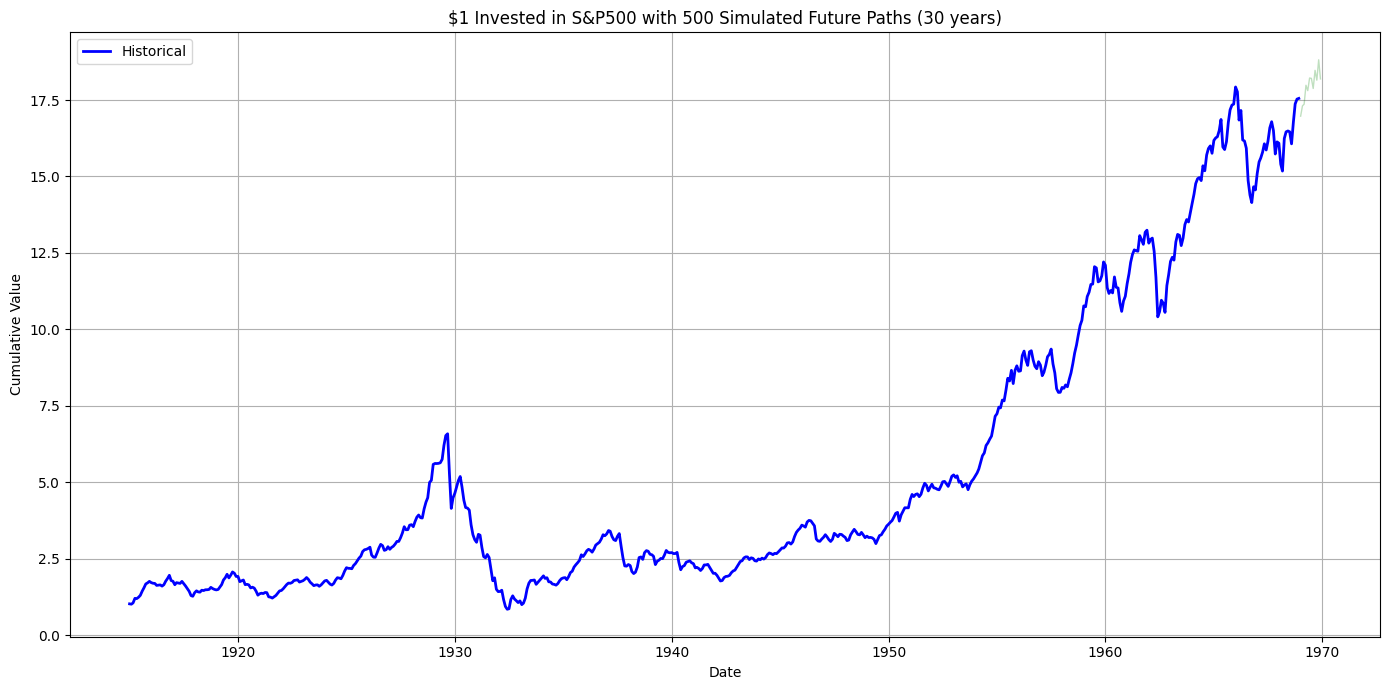

In [73]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Parameters
index = 'S&P500'
n_months = 12
n_paths = 1

# Historical cumulative return
hist_returns = df_returns[index].dropna()
hist_cumulative = (1 + hist_returns).cumprod()
last_value = hist_cumulative.iloc[-1]

# Dates for simulated paths
sim_start = hist_cumulative.index[-1] + pd.offsets.MonthBegin()
sim_dates = pd.date_range(start=sim_start, periods=n_months, freq='MS')

# Plot
plt.figure(figsize=(14, 7))

# Plot all simulated paths in faint gray
for i in range(n_paths):
    sim_returns = sim.simulate(n_months, seed=i+1000)[index]
    sim_cumulative = (1 + sim_returns).cumprod() * last_value
    plt.plot(sim_dates, sim_cumulative, color='green', alpha=0.25, linewidth=1)

# Plot historical in blue on top
plt.plot(hist_cumulative, color='blue', label='Historical', linewidth=2)

plt.title(f"$1 Invested in {index} with 500 Simulated Future Paths (30 years)")
plt.ylabel("Cumulative Value")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
